
Goal
- visualize text statistics w.r.t. data subsets obtaind from pruning

In [2]:
from rosemary import jpt_parse_args, jpt_setup, jpt_in_notebook; jpt_setup()

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
import os
import sys
import numpy as np
import time
import re
from functools import partial

from collections import defaultdict
import glob

import matplotlib.pyplot as plt

import pickle
import pandas as pd
from tqdm import tqdm 

import pyarrow
import torch
import transformers
from transformers import AutoTokenizer

from datasets import load_dataset

In [4]:
from note_pruning_analysis import (
    assets_dir,
    data_inds_dir,
    processed_dir,
    lm_output_dir,
    get_dataset,
    get_dataset_token_lengths,
    get_lm_output,
    get_sorted_inds,
    get_prune_results,
)

### verify if there is correlation between output scores with output token length

In [5]:

# model_name = 'llama-7b'; model_name_or_path='../results/baselines/huggyllama/llama-7b'
model_name = 'llama-7b+lora:r=256:a=256'; model_name_or_path='../results/baselines/huggyllama/llama-7b'

tokenizer = AutoTokenizer.from_pretrained(model_name_or_path, use_fast=True)
tokenizer.padding_side = 'left'
if tokenizer.pad_token is None:
    tokenizer.pad_token = tokenizer.eos_token

Using pad_token, but it is not set yet.


In [6]:
subsample_size = 2000


# get a list of dataset names.
dataset_list = [os.path.basename(x).split('.')[0] 
 for x in glob.glob(os.path.join(lm_output_dir, model_name, '*.pkl'))]
dataset_list = [x for x in dataset_list if 'flan2022' not in x]


lm_outputs = {}
token_lengths = {}
for dataset in dataset_list:
    lm_outputs[dataset] = get_lm_output(dataset, model_name)
    if subsample_size:
        np.random.seed(0)
        inds = np.random.randint(0, list(lm_outputs[dataset].values())[0].shape[0], subsample_size)
    for k, v in lm_outputs[dataset].items():
        lm_outputs[dataset][k] = v[inds]
    token_lengths[dataset] = get_dataset_token_lengths(
        dataset, model_name_or_path, tokenizer, inds=inds if subsample_size else None)


[2023-10-09 14:57:19,735] [INFO] [real_accelerator.py:158:get_accelerator] Setting ds_accelerator to cuda (auto detect)


Found cached dataset json (/gpfs/u/scratch/PTFM/PTFMqngp/huggingface_cache/datasets/json/default-2c6b12c2f11c0937/0.0.0/8bb11242116d547c741b2e8a1f18598ffdd40a1d4f2a2872c7a28b697434bc96)


  0%|          | 0/1 [00:00<?, ?it/s]

Loading cached processed dataset at /gpfs/u/scratch/PTFM/PTFMqngp/huggingface_cache/datasets/json/default-2c6b12c2f11c0937/0.0.0/8bb11242116d547c741b2e8a1f18598ffdd40a1d4f2a2872c7a28b697434bc96/cache-eb938f2a6da5e5da_*_of_00016.arrow


Map (num_proc=16):   0%|          | 0/2000 [00:00<?, ? examples/s]

Found cached dataset json (/gpfs/u/scratch/PTFM/PTFMqngp/huggingface_cache/datasets/json/default-deef786a5f2992f0/0.0.0/8bb11242116d547c741b2e8a1f18598ffdd40a1d4f2a2872c7a28b697434bc96)


  0%|          | 0/1 [00:00<?, ?it/s]

Loading cached processed dataset at /gpfs/u/scratch/PTFM/PTFMqngp/huggingface_cache/datasets/json/default-deef786a5f2992f0/0.0.0/8bb11242116d547c741b2e8a1f18598ffdd40a1d4f2a2872c7a28b697434bc96/cache-c30f84a2dc784550_*_of_00016.arrow


Map (num_proc=16):   0%|          | 0/2000 [00:00<?, ? examples/s]

Found cached dataset json (/gpfs/u/scratch/PTFM/PTFMqngp/huggingface_cache/datasets/json/default-ffcb06a83b4338ce/0.0.0/8bb11242116d547c741b2e8a1f18598ffdd40a1d4f2a2872c7a28b697434bc96)


  0%|          | 0/1 [00:00<?, ?it/s]

Loading cached processed dataset at /gpfs/u/scratch/PTFM/PTFMqngp/huggingface_cache/datasets/json/default-ffcb06a83b4338ce/0.0.0/8bb11242116d547c741b2e8a1f18598ffdd40a1d4f2a2872c7a28b697434bc96/cache-a5113a0d5a91ea53_*_of_00016.arrow


Map (num_proc=16):   0%|          | 0/2000 [00:00<?, ? examples/s]

Found cached dataset json (/gpfs/u/scratch/PTFM/PTFMqngp/huggingface_cache/datasets/json/default-db45fcd570bec348/0.0.0/8bb11242116d547c741b2e8a1f18598ffdd40a1d4f2a2872c7a28b697434bc96)


  0%|          | 0/1 [00:00<?, ?it/s]

Loading cached processed dataset at /gpfs/u/scratch/PTFM/PTFMqngp/huggingface_cache/datasets/json/default-db45fcd570bec348/0.0.0/8bb11242116d547c741b2e8a1f18598ffdd40a1d4f2a2872c7a28b697434bc96/cache-3da14401ed1f756e_*_of_00016.arrow


Map (num_proc=16):   0%|          | 0/2000 [00:00<?, ? examples/s]

Found cached dataset json (/gpfs/u/scratch/PTFM/PTFMqngp/huggingface_cache/datasets/json/default-053c40899badb561/0.0.0/8bb11242116d547c741b2e8a1f18598ffdd40a1d4f2a2872c7a28b697434bc96)


  0%|          | 0/1 [00:00<?, ?it/s]

Loading cached processed dataset at /gpfs/u/scratch/PTFM/PTFMqngp/huggingface_cache/datasets/json/default-053c40899badb561/0.0.0/8bb11242116d547c741b2e8a1f18598ffdd40a1d4f2a2872c7a28b697434bc96/cache-56e3fe188fc9e223_*_of_00016.arrow


Map (num_proc=16):   0%|          | 0/2000 [00:00<?, ? examples/s]

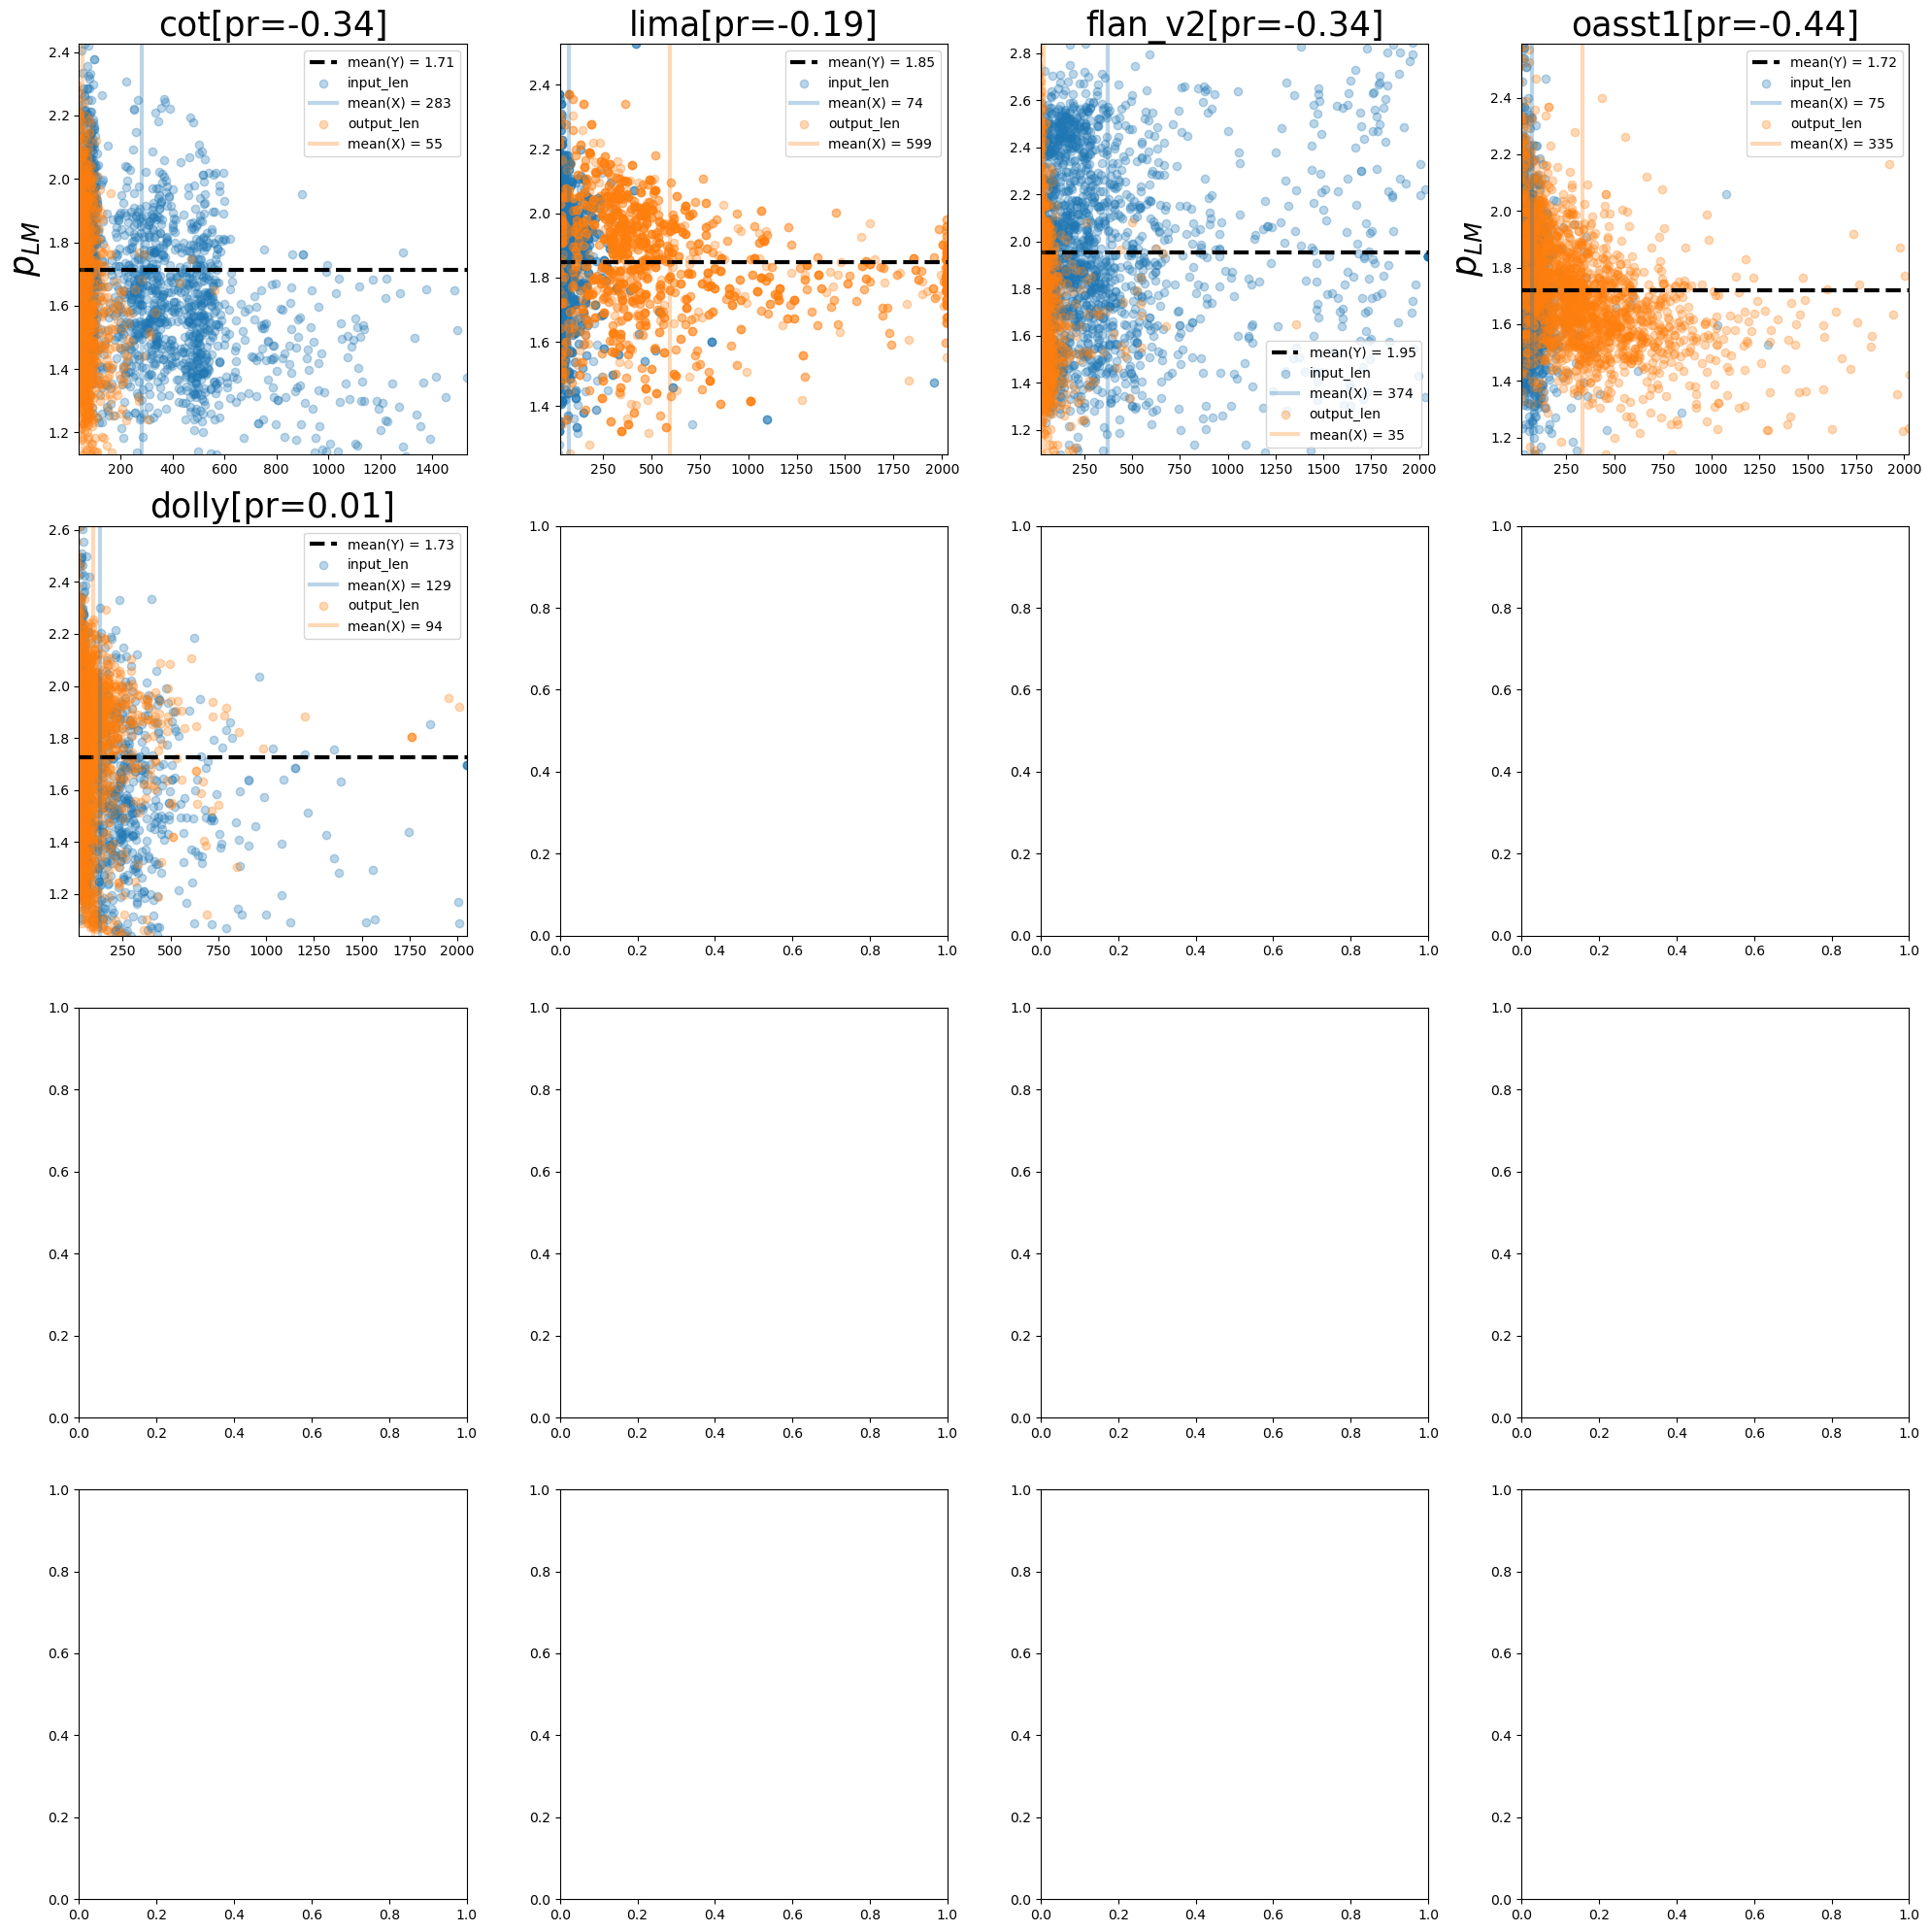

In [16]:

y_label = 'log_prob'
y_label = 'el2n_agg=mean'

w = 5
fig, axs = plt.subplots(4,4, figsize=(w*4,w*4))

for axi, dataset in enumerate(dataset_list):
    
    ## get the information
    logP = lm_outputs[dataset][y_label]
    ys = np.exp(logP)
    input_len = token_lengths[dataset]['input_len']
    output_len = token_lengths[dataset]['output_len']
    
    ## plot the information 
    ax = axs.flatten()[axi]

    
    mean_y = ys.mean()
    ax.axhline(y=mean_y, color='k', linestyle='--', linewidth=3, label=f'mean(Y) = {mean_y:.2f}')

    for label, xs in [
            ('input_len', input_len),
            ('output_len', output_len),
        ]:
        scatter = ax.scatter(xs, ys, label=label, alpha=.3)
        mean_x = xs.mean()
        ax.axvline(x=mean_x, color=scatter.get_facecolor()[0], linestyle='-', linewidth=3, label=f'mean(X) = {mean_x:.0f}')


    ax.legend()
    eps = .001

    ax.set_ylim(np.quantile(ys, eps), np.quantile(ys, 1-eps))
    xs_for_xlim = np.maximum(input_len, output_len)
    ax.set_xlim(np.quantile(xs_for_xlim, eps), np.quantile(xs_for_xlim, 1-eps))
    
    # ax.set_xlabel('token lengths', fontsize=20)
    if axi%3 == 0:
        ax.set_ylabel('$p_{LM}$', fontsize=25)
        
        
    corr = compute_correlations(xs, ys, 'pearsonr')
    ax.set_title(f'{dataset}[pr={corr:.2f}]', fontsize=25)

    
    
fig.tight_layout()
save_path = os.path.join(assets_dir, 'note_pruning_analysis_prob_vs_tokenlen.png')
# fig.savefig(save_path, bbox_inches='tight', dpi=100)

### analyze difference/similarity between sorted indices with different `sort_by`. see if they correlate with each other, e.g., first k item overlap.


In [5]:
from note_pruning_analysis import compute_correlations

In [39]:
pkl_files = glob.glob(os.path.join(data_inds_dir, '**/**/*.pkl'))
pkl_files = [get_prune_results(x) for x in pkl_files]

dfo = pd.DataFrame(pkl_files)
dfo

,model_name,dataset,sort_by,pkl_path,inds,S
0,pythia-1b-deduped,cot,kmeansl2_nc=3000_incr,/gpfs/u/home/PTFM/PTFMqngp/scratch/github/miti...,"[33040, 20796, 20778, 53475, 20753, 53467, 692...","[14.19522641596984, 9.780138445664921, 16.8840..."
1,pythia-1b-deduped,cot,grad_last_l2n_incr,/gpfs/u/home/PTFM/PTFMqngp/scratch/github/miti...,"[35469, 41233, 46411, 75629, 69637, 59780, 767...","[23.100366592407227, 4.731935501098633, 11.848..."
2,pythia-1b-deduped,cot,el2n_agg=mean_decr,/gpfs/u/home/PTFM/PTFMqngp/scratch/github/miti...,"[16291, 90361, 45738, 22332, 31730, 34875, 688...","[0.81982421875, 0.246826171875, 0.4482421875, ..."
3,pythia-1b-deduped,cot,logit_margin_decr,/gpfs/u/home/PTFM/PTFMqngp/scratch/github/miti...,"[46411, 83671, 69637, 75629, 73593, 91155, 597...","[-2.025390625, 4.4609375, 1.1318359375, -0.892..."
4,pythia-1b-deduped,cot,log_prob_incr,/gpfs/u/home/PTFM/PTFMqngp/scratch/github/miti...,"[55989, 14529, 45738, 35321, 24767, 85538, 927...","[-3.52734375, -0.85498046875, -1.9169921875, -..."
...,...,...,...,...,...,...
203,pythia-1b-deduped+lora:r=256:a=256,oasst1,el2n_agg=l2n_decr,/gpfs/u/home/PTFM/PTFMqngp/scratch/github/miti...,"[26268, 26269, 26267, 11698, 11696, 26856, 888...","[13.03125, 14.71875, 11.5390625, 10.40625, 24...."
204,pythia-1b-deduped+lora:r=256:a=256,oasst1,el2n_agg=mean_incr,/gpfs/u/home/PTFM/PTFMqngp/scratch/github/miti...,"[11073, 17484, 18002, 16639, 18234, 18235, 128...","[0.69580078125, 0.595703125, 0.716796875, 0.68..."
205,pythia-1b-deduped+lora:r=256:a=256,oasst1,el2n_agg=l2n_incr,/gpfs/u/home/PTFM/PTFMqngp/scratch/github/miti...,"[19045, 12312, 12398, 414, 22862, 14992, 24158...","[13.03125, 14.71875, 11.5390625, 10.40625, 24...."
206,pythia-1b-deduped+lora:r=256:a=256,oasst1,kmeansl2_nc=3000_decr,/gpfs/u/home/PTFM/PTFMqngp/scratch/github/miti...,"[26267, 26269, 26268, 22468, 8481, 17485, 2432...","[10.099533841222962, 0.0, 21.42898308798626, 2..."


In [81]:
model_name = 'llama-7b'
model_name = 'llama-7b+lora:r=256:a=256'
dataset = 'flan2022_1m'

# model_name = 'pythia-1b-deduped'
# dataset = 'lima'

ds = get_dataset(dataset)
ds_len = len(ds)

filter_fn = lambda x: \
    x['model_name'].startswith(model_name) and \
    x['dataset'] == dataset


df = dfo.copy()
df = df[df.apply(filter_fn, axis=1)]
df = df.sort_values('sort_by')
df = df.reset_index(drop=True)
df = df[df['sort_by'].apply(lambda x: 'decr' not in x)] # just increasing score.
df = df[~df['S'].isnull()]
print(df['sort_by'].tolist())

df.head(3)

Found cached dataset json (/gpfs/u/scratch/PTFM/PTFMqngp/huggingface_cache/datasets/json/default-e0d9fc5c6c793f44/0.0.0/8bb11242116d547c741b2e8a1f18598ffdd40a1d4f2a2872c7a28b697434bc96)


  0%|          | 0/1 [00:00<?, ?it/s]

['el2n_agg=l2n_incr', 'el2n_agg=mean_incr', 'grad_loraB_l2n_incr', 'kmeanscd_nc=3000_incr', 'kmeansl2_nc=3000_incr', 'kmeansl2_nc=6000_incr', 'log_prob_incr', 'logit_margin_incr']


,model_name,dataset,sort_by,pkl_path,inds,S
1,llama-7b+lora:r=256:a=256,flan2022_1m,el2n_agg=l2n_incr,/gpfs/u/home/PTFM/PTFMqngp/scratch/github/miti...,"[301330, 302722, 105401, 18583, 573964, 104154...","[15.228386878967285, 17.626447677612305, 2.021..."
3,llama-7b+lora:r=256:a=256,flan2022_1m,el2n_agg=mean_incr,/gpfs/u/home/PTFM/PTFMqngp/scratch/github/miti...,"[264171, 170438, 143100, 303968, 146801, 79995...","[0.6945843696594238, 0.5873650908470154, 0.986..."
5,llama-7b+lora:r=256:a=256,flan2022_1m,grad_loraB_l2n_incr,/gpfs/u/home/PTFM/PTFMqngp/scratch/github/miti...,"[402518, 402148, 402021, 401969, 898918, 74557...","[0.7041050791740417, 0.44840115308761597, 16.2..."


In [ ]:

df




In [43]:
sort_by_list = df['sort_by'].tolist()
inds_list = df['inds'].tolist()
scores_list = df['S'].tolist()

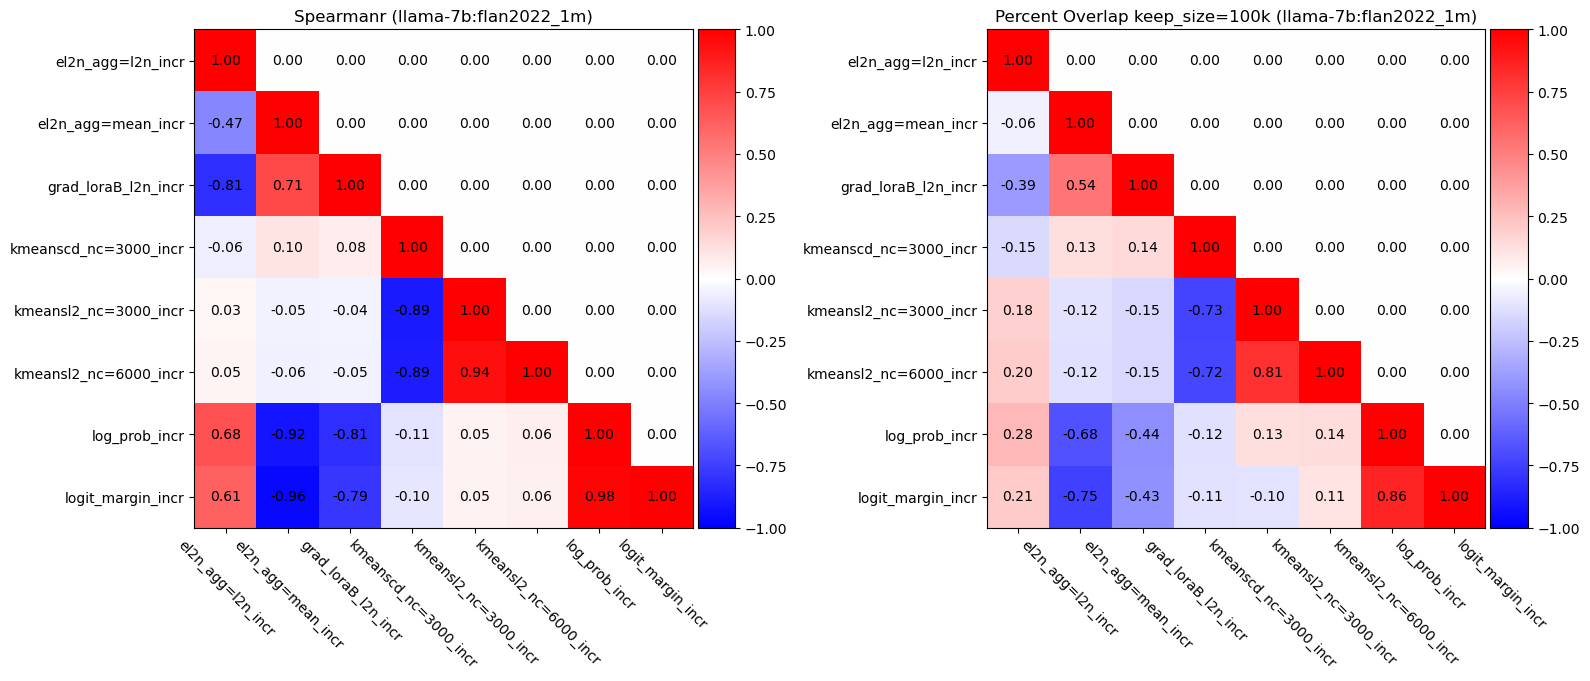

In [75]:
from rosemary import plt_kernel_matrix_one
import matplotlib.pyplot as plt
from scipy import stats

M = 100000
N = len(scores_list)
rank_corr = np.zeros((N, N))
overlap = np.zeros((N, N))
for i in range(N):
    for j in range(N):
        scores_i = scores_list[i]
        scores_j = scores_list[j]
        inds_i = inds_list[i]
        inds_j = inds_list[j]
        if j < i:
            rank_corr[i,j] = stats.spearmanr(scores_i, scores_j).statistic
            positive_overlap = len(np.intersect1d(inds_i[:M], inds_j[:M]))/M
            negative_overlap = -(
                len(np.intersect1d(inds_i[-M:], inds_j[:M]))/M + 
                len(np.intersect1d(inds_i[:M], inds_j[-M:]))/M
            )/2
            overlap[i,j] = positive_overlap if positive_overlap+negative_overlap>0 else negative_overlap
        if i == j:
            rank_corr[i, j] = 1
            overlap[i, j] = 1
        

fig, axs = plt.subplots(1, 2, figsize=(16,8))
ax = axs[0]
plt_kernel_matrix_one(
    fig, ax, rank_corr, title=f'Spearmanr ({model_name}:{dataset})', 
    vmin=-1, vmax=1, cmap='bwr', n_ticks=N, annotate=True)
ax.set_xticklabels(sort_by_list, rotation=-45)
ax.set_yticklabels(sort_by_list)

ax = axs[1]
plt_kernel_matrix_one(
    fig, ax, overlap, title=f'Percent Overlap keep_size={M/1000:.0f}k ({model_name}:{dataset})', 
    vmin=-1, vmax=1, cmap='bwr', n_ticks=N, annotate=True)
ax.set_xticklabels(sort_by_list, rotation=-45, ha='left')
ax.set_yticklabels(sort_by_list)

fig.tight_layout()

save_path = os.path.join(
    assets_dir, f'note_pruning_analysis_rank_corr_{model_name}:{dataset}.png')
# fig.savefig(save_path, bbox_inches='tight', dpi=100)

### visualize text statistics w.r.t. data subsets obtaind from pruning, e.g., token length, P_LM, etc.

In [ ]:
from scipy.interpolate import make_interp_spline

smooth_kernel_size = 20
# xs_max = total_data_size # M_min
# xs_max = M_min

ylabel_list = ['$P_{LM}$', 'input_len', 'output_len', 'pruning_score']
# sort_by_list = [
#     'dppmap_k=Kcos', 'dppmap_k=Kcos1np',
#     'dppmap_k=Kcosp', 
#     'prob_decr', 
#     'kmeansl2_nc=3000_decr',
#     'random',
# ]

N = len(ylabel_list)
fig, axs = plt.subplots(2, N ,figsize=(5*N, 5*2))

for i, xs_max in enumerate([M_min, total_data_size]):

    for j, ylabel in enumerate(ylabel_list):
        ax = axs[i, j]

        for sort_by in sort_by_list:
            I = np.array(inds[sort_by]['inds'])
            xs = np.round(np.linspace(0, min(xs_max, len(I))-1, 1000)).astype(np.int32)

            if ylabel == '$P_{LM}$':
                ys = logP[I[xs]].squeeze()
                ys = np.exp(ys)
            elif ylabel == 'input_len':
                ys = input_len[I[xs]]
            elif ylabel == 'output_len':
                ys = output_len[I[xs]]
            elif ylabel == 'pruning_score':
                if 'S' not in inds[sort_by]:
                    continue
                ys = np.array(inds[sort_by]['S']).squeeze()[xs]
            else:
                continue

            line, = ax.plot(xs/total_data_size, ys, alpha=.05)
            color = line.get_color()
            ys_smoothed = np.convolve(ys, np.ones(smooth_kernel_size)/smooth_kernel_size, mode='same')
            ax.plot(xs/total_data_size, ys_smoothed, color=color, label=sort_by)

        ax.legend()
        ax.set_ylabel(ylabel, fontsize=25)
        ax.set_xlabel('% Data Selected', fontsize=25)

        if ylabel in ['input_len', 'output_len']:
            ax.set_ylim((0, 700))

suptitle = f'[{dataset}] Text statistics for data subsets'
fig.suptitle(suptitle, fontsize=30)
fig.tight_layout()

save_path = os.path.join(
    assets_dir, f'note_pruning_analysis_text_statistics_trend_{dataset}.png')
fig.savefig(save_path, bbox_inches='tight', dpi=100)